In [1]:
# Initialization boilerplate
from typing import *

import os
import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core
import pandas as pd
import urllib

import ray
import spacy
import multiprocessing
import time
import threading
import matplotlib.pyplot as plt

import textwrap
from IPython.core.display import display, HTML

_PROJECT_ROOT = "../.."
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    # If we're running from within the project source tree and the parent Python
    # environment doesn't have the text_extensions_for_pandas package, use the
    # version in the local source tree.
    if not os.getcwd().endswith("market"):
        raise e
    import sys
    if _PROJECT_ROOT not in sys.path:
        sys.path.insert(0, _PROJECT_ROOT)
    import text_extensions_for_pandas as tp



api_key = os.environ.get("IBM_API_KEY")
service_url = os.environ.get("IBM_SERVICE_URL")  
natural_language_understanding = ibm_watson.NaturalLanguageUnderstandingV1(
    version="2021-01-01",
    authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key)
)
natural_language_understanding.set_service_url(service_url)

# Part 3: Make it fast with Pandas

In the first two parts of this series, we explained how to use Text Extensions for Pandas and IBM Watson Natural Language Understanding to implement an example Market Intelligence application of natural language processing. Our example task involved identifying names and titles of executives in corporate press releases.

Parts 1 and 2 of this series laid out this process in great detail, but we can summarize the high-level flow in four steps:

1. Use IBM Watson Natural Language Understanding to extract semantic roles and person mentions from the press release.
2. Used Text Extensions for Pandas to convert those model outputs to Pandas DataFrames. Then cross-reference the data in those DataFrames to find the places where the press release quoted a person by name.
3. Use SpaCy's dependency parser to extract information about the relationships between the words of the press release.
4. Use Text Extensions for Pandas to process the parser's output and identify the titles of the persons we had identified earlier.

In this part of the series, we're going to turn four-step approach approach for identifying executives in a given press release into a program that mines this information from many press releases. 

Conceptually, our processing pipeline will look like this:

![First version of our processing pipeline](images/pipeline_v1.png)


Press releases go in on the left, and each document goes through the four steps of processing we've described so far. Then a fifth step combines all the results of that processing into a table of names and titles of executives. 

Let's quickly review what the outputs of the first four steps of processing look and how we surface these steps in our companion Python code. 



*TODO: Insert here a description of how we share the Python file `market_intelligence.py`*

In [2]:
import market_intelligence as mi

We'll use one year's worth of press releases from [the IBM news room](https://newsroom.ibm.com/announcements) --- 191 press releases, to be exact.
This data set is just big enough to illustrate the performance differences between the different approaches we're about to explore.
A typical real-world market intelligence application would use thousands or millions of articles.

`market_intelligence.py` contains code to download and cache this small corpus.

In [3]:
articles = mi.maybe_download_articles()
articles

No cached documents; downloading them.


,url,html
0,https://newsroom.ibm.com/2020-02-04-The-Avril-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
1,https://newsroom.ibm.com/2020-02-11-IBM-X-Forc...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
2,https://newsroom.ibm.com/2020-02-18-IBM-Study-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
3,https://newsroom.ibm.com/2020-02-19-IBM-Power-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
4,https://newsroom.ibm.com/2020-02-20-Centotrent...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
...,...,...
186,https://newsroom.ibm.com/2021-01-25-OVHcloud-t...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
187,https://newsroom.ibm.com/2021-01-26-Luminor-Ba...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
188,https://newsroom.ibm.com/2021-01-26-DIA-Levera...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
189,https://newsroom.ibm.com/2021-01-26-IBM-Board-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."


Let's recap the analysis steps we laid out in detail in parts 1 and 2, using the same example document as before. This document is one of the documents in our DataFrame `articles`:

In [4]:
example_doc_url = "https://newsroom.ibm.com/2021-01-04-IBM-Study-Majority-of-Surveyed-Companies-are-Not-Prepared-for-IT-Needs-of-the-Future-Say-U-S-and-U-K-Tech-Leaders"
example_doc_html = articles.loc[articles["url"] == example_doc_url, "html"].values[0]
display(HTML(textwrap.shorten(example_doc_html, 5000)))

The first processing step extracts named entities and semantic roles with IBM Watson Natural Language Understanding.


In [5]:
step_1_results = (
    mi.extract_named_entities_and_semantic_roles(example_doc_html, 
                                                 natural_language_understanding)
)
textwrap.shorten(str(step_1_results), 1000)

"{'usage': {'text_units': 1, 'text_characters': 4397, 'features': 2}, 'semantic_roles': [{'subject': {'text': 'Nearly a quarter of CIOs and CTOs surveyed'}, 'sentence': '- Nearly a quarter of CIOs and CTOs surveyed say they are just starting their IT modernization journey or have yet to begin modernizing.', 'object': {'text': 'they are just starting their IT modernization journey or have yet to begin modernizing'}, 'action': {'verb': {'text': 'say', 'tense': 'present'}, 'text': 'say', 'normalized': 'say'}}, {'subject': {'text': 'they'}, 'sentence': '- Nearly a quarter of CIOs and CTOs surveyed say they are just starting their IT modernization journey or have yet to begin modernizing.', 'action': {'verb': {'text': 'be', 'tense': 'present'}, 'text': 'are', 'normalized': 'be'}}, {'subject': {'text': 'they'}, 'sentence': '- Nearly a quarter of CIOs and CTOs surveyed say they are just starting their IT modernization journey or have yet to begin modernizing.', 'object': {'text': 'yet to [...

The second processing step uses Text Extensions for Pandas to convert these model outputs into DataFrames, then uses these DataFrames to identify persons that the document quotes by name:

In [6]:
step_2_results = mi.identify_persons_quoted_by_name(step_1_results)
step_2_results

,subject,person
0,"[1775, 1860): 'Archana Vemulapalli, General Ma...","[1775, 1794): 'Archana Vemulapalli'"


The third processing step uses SpaCy to perform dependency parsing over the document, then uses Text Extensions for Pandas to convert the dependency parse into a DataFrame:

In [7]:
# Retrieve the detagged document text that Watson Natural Language Understanding
# produced from the original HTML document.
doc_text = step_1_results["analyzed_text"]

# Fire up SpaCy's deep learning-based dependency parser.
spacy_language_model = spacy.load("en_core_web_trf")

step_3_results = mi.perform_dependency_parsing(doc_text, spacy_language_model)
step_3_results.head(3)

,id,span,tag,dep,head
0,0,"[0, 1): '-'",:,punct,9
1,1,"[2, 8): 'Nearly'",RB,advmod,3
2,2,"[9, 10): 'a'",DT,quantmod,3


The fourth processing step uses Text Extensions for Pandas to process the parser's output and identify the titles of the persons we had identified back in step 2.

In [8]:
step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
step_4_results                                       

,person,title
0,"[1775, 1794): 'Archana Vemulapalli'","[1796, 1860): 'General Manager, IBM Infrastruc..."


We can roll up these four steps into a single Python function:

In [9]:
def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    step_3_results = mi.perform_dependency_parsing(step_1_results["analyzed_text"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results

Now we've summarized the four steps that make up the processing from Part 1 and Part 2. Let's talk about the fifth step: **combining results across documents**.

We can implement our whole pipeline by running steps 1-4 in a for loop over the `html` column of our DataFrame of articles, building up a list of DataFrames, then stacking all the DataFrames into a single table of executives and titles:

In [10]:
# Replicate initialization code in a separate cell so other code can use it when we
# don't run the 15-minute cell that follows.
nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
nlu_api.set_service_url(service_url)
spacy_language_model = spacy.load("en_core_web_trf")

In [11]:
%%time

nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
nlu_api.set_service_url(service_url)
spacy_language_model = spacy.load("en_core_web_trf")

# Repeat steps 1-4 on every document
dataframes_to_stack = [
    steps_1_through_4(doc_html) for doc_html in articles["html"]
]

# Step 5: Merge the results across documents
step_5_results = pd.concat(dataframes_to_stack)
step_5_results

CPU times: user 11min 31s, sys: 36.1 s, total: 12min 7s
Wall time: 15min 13s


,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."
0,"[1281, 1292): 'Rob DiCicco'","[1294, 1348): 'PharmD, Deputy Chief Health Off..."
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
0,"[2290, 2298): 'Bob Lord'","[2300, 2376): 'IBM Senior Vice President of Co..."
...,...,...
0,"[3113, 3123): 'Mike Doran'","[3125, 3156): 'Worldwide Sales Director at IBM'"
0,"[3156, 3170): 'Howard Boville'","[3172, 3211): 'Senior Vice President, IBM Hybr..."
0,"[3116, 3128): 'Samuel Brack'","[3129, 3154): 'Co-Founder and CTO at DIA'"
1,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"


This loop takes about 15 minutes. That's a tolerable amount of time for this small collection of documents, but we will need better performance to work at more realistic scales.

In [12]:
# Temporary
import importlib
mi = importlib.reload(mi)

In [13]:
# TODO: Don't include this cell in the main flow, but do include the graph that the next cell 
# produces.
if not os.path.exists("ibm_press_release_timings.csv"):
    # Cached timing data not present. Regenerate it.
    benchmark_api_key = api_key
    benchmark_service_url = service_url
    #benchmark_api_key = os.environ.get("STANDARD_API_KEY")
    #benchmark_service_url = os.environ.get("STANDARD_SERVICE_URL")  

    nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
                authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(benchmark_api_key))
    nlu_api.set_service_url(benchmark_service_url)
    spacy_language_model = spacy.load("en_core_web_trf")

    dataframes_to_stack = []
    timings = []

    article_subset = articles

    for url, html in zip(article_subset["url"], article_subset["html"]):

        start_time = time.time()

        step_1_results = mi.extract_named_entities_and_semantic_roles(html, nlu_api)
        step_1_time = time.time()

        step_2_results = mi.identify_persons_quoted_by_name(step_1_results)
        step_2_time = time.time()

        step_3_results = mi.perform_dependency_parsing(step_1_results["analyzed_text"],
                                                       spacy_language_model)
        step_3_time = time.time()
        
        step_3a_results = mi.perform_targeted_dependency_parsing(step_2_results["person"],
                                                       spacy_language_model)
        step_3a_time = time.time()

        step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
        step_4_time = time.time()

        dataframes_to_stack.append(step_4_results)
        timings.append({
            "url": url,
            "step_1_sec": step_1_time - start_time,
            "step_2_sec": step_2_time - step_1_time,
            "step_3_sec": step_3_time - step_2_time,
            "step_3a_sec": step_3a_time - step_3_time,
            "step_4_sec": step_4_time - step_3a_time
        })

    step_5_start_time = time.time()
    step_5_results = pd.concat(dataframes_to_stack)
    step_5_time = time.time() - step_5_start_time
    print(f"Step 5 took {step_5_time:1.3f} sec.")
    
    pd.DataFrame.from_records(timings).to_csv("ibm_press_release_timings.csv")

timings_df = pd.read_csv("ibm_press_release_timings.csv")
timings_df

Step 5 took 0.018 sec.


,Unnamed: 0,url,step_1_sec,step_2_sec,step_3_sec,step_3a_sec,step_4_sec
0,0,https://newsroom.ibm.com/2020-02-04-The-Avril-...,1.862320,0.016338,3.004091,0.000756,0.000355
1,1,https://newsroom.ibm.com/2020-02-11-IBM-X-Forc...,1.691982,0.014628,6.299724,0.279742,0.058784
2,2,https://newsroom.ibm.com/2020-02-18-IBM-Study-...,0.591747,0.015970,1.997488,0.227126,0.031569
3,3,https://newsroom.ibm.com/2020-02-19-IBM-Power-...,1.312670,0.016511,2.100122,0.468009,0.046466
4,4,https://newsroom.ibm.com/2020-02-20-Centotrent...,0.832156,0.015510,2.638439,0.000815,0.000407
...,...,...,...,...,...,...,...
186,186,https://newsroom.ibm.com/2021-01-25-OVHcloud-t...,1.656452,0.019440,3.198839,0.193426,0.041599
187,187,https://newsroom.ibm.com/2021-01-26-Luminor-Ba...,0.805396,0.019716,2.412397,0.192089,0.036973
188,188,https://newsroom.ibm.com/2021-01-26-DIA-Levera...,1.069458,0.015876,2.975903,0.414899,0.035852
189,189,https://newsroom.ibm.com/2021-01-26-IBM-Board-...,0.404145,0.019680,0.229588,0.000811,0.000403


In [14]:
timings_df.sum()

Unnamed: 0                                                 18145
url            https://newsroom.ibm.com/2020-02-04-The-Avril-...
step_1_sec                                            197.052967
step_2_sec                                              3.144257
step_3_sec                                             665.38904
step_3a_sec                                            74.394759
step_4_sec                                              7.789007
dtype: object

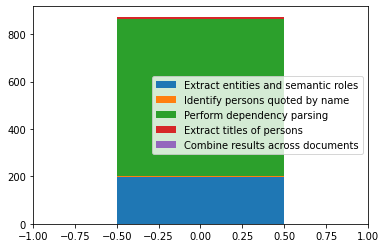

In [15]:
# TODO: Pretty up this plot and get the legend in the same order as the bars
sums = timings_df.sum()
timings = {
    "Extract entities and semantic roles": sums["step_1_sec"],
    "Identify persons quoted by name": sums["step_2_sec"],
    "Perform dependency parsing": sums["step_3_sec"],
    "Extract titles of persons": sums["step_4_sec"],
    "Combine results across documents": 0.062  # Manually pasted from output of previous cell
}

cur_sum = 0
for k, v in timings.items():
    plt.bar([0], [v], bottom=cur_sum, label=k, width=1)
    cur_sum += v
plt.xlim([-1, 1])
plt.legend()
plt.show()

We can use this for loop 

If we insert a few timing measurements into this code, we can determine the amount of time the code spent in each step across these 190 articles. 

TODO: Insert graph of timings (see previous cell)

the dominant cost is running the deep parser

obviously we can make that step run faster with parallelism

but it's a good idea to exhaust the easy options for good single-threaded performance first

so let's make the parsing step go faster using Pandas

## Using Pandas to make dependency parsing faster
Observation: We only use portion of the the dependency parse that is reachable from the person mentions.

Observation: Each sentence of the document produces a disjoint parse tree.

Observation: Each sentence is an independent unit of work for the parser.

This means that we can parse just the sentences containing the person mentions and get the same answer as if we parsed every sentence. And parsing just one sentence is much faster.

Finding sentence boundaries without parsing can be tricky, but fortunately we don't need to find every sentence boundary with 100 percent accuracy to make this approach work. We just need to find enough accurate sentence boundaries to eliminate most of the document.

For this data set, we have reliable paragraph metadata. The source documents are HTML files with paragraphs denoted by HTML `<p>` tags. Watson Natural Language Underderstanding's HTML to text conversion reliably turns the paragraph tags into newline characters.

With a few lines of Python, we can generate a `SpanArray` with one span for each paragraph in the document:

In [16]:
import regex
paragraph_break_re = regex.compile(r"\n+")

def find_paragraph_spans(doc_text: str):
    # Find paragraph boundaries
    break_locs = [(a.start(), a.end()) 
                  for a in regex.finditer(paragraph_break_re, doc_text)]
    boundaries = break_locs + [(len(doc_text), len(doc_text))]
    
    # Split the document on paragraph boundaries
    begins = []
    ends = []
    begin = 0
    for b in boundaries:
        end = b[0]
        if end > begin:  # Ignore zero-length paragraphs
            begins.append(begin)
            ends.append(end)
        begin = b[1]
    return tp.SpanArray(doc_text, begins, ends)

The output of the `find_paragraph_spans()` is a `SpanArray` that is ready for processing with Pandas.
It can even render itself as HTML.

In [17]:
example_text = """
This is a the first paragraph.
Second paragraph here. 

Third paragraph comes after two newlines."""

find_paragraph_spans(example_text)

0,1,31,This is a the first paragraph.
1,32,55,Second paragraph here.
2,57,98,Third paragraph comes after two newlines.



We'll use [document number 3](https://newsroom.ibm.com/2020-02-19-IBM-Power-Systems-Certified-for-SAP-HANA-R-Enterprise-Cloud-as-a-provider-for-large-SAP-HANA-systems) as an example here, because it contains quotes from more than one person.

In [18]:
# Pick a document than quotes more than one executive.
doc_html = articles.iloc[3]["html"]
step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
step_2_results

,subject,person
0,"[1213, 1281): 'Christoph Herman, SVP and Head ...","[1213, 1229): 'Christoph Herman'"
1,"[2227, 2519): 'Stephen Leonard, General Manage...","[2227, 2242): 'Stephen Leonard'"


The `mi.perform_dependency_parsing()` function that we've been using so far is actually only one line of Python code:
```python
def perform_dependency_parsing(doc_text: str, spacy_language_model):
    """
    First phase of processing from the second part of the series.
    
    Parses a document using SpaCy's depdendency parser, then converts the
    outputs of the parser into a Pandas DataFrame using Text Extensions for Pandas.
    """
    return (
        tp.io.spacy.make_tokens_and_features(doc_text, spacy_language_model)
        [["id", "span", "tag", "dep", "head"]])
```

Let's pull out that one line and run it on our example document:

In [19]:
doc_text = step_1_results["analyzed_text"]
spacy_language_model = spacy.load("en_core_web_trf")

# Parse the document.
parse_features = tp.io.spacy.make_tokens_and_features(
            doc_text, spacy_language_model)[["id", "span", "tag", "dep", "head"]]
parse_features

,id,span,tag,dep,head
0,0,"[0, 6): 'ARMONK'",NNP,ROOT,0
1,1,"[6, 7): ','",",",punct,0
2,2,"[8, 12): 'N.Y.'",NNP,appos,0
3,3,"[12, 13): ','",",",punct,0
4,4,"[14, 18): 'Feb.'",NNP,npadvmod,0
...,...,...,...,...,...
675,675,"[3791, 3802): 'explanation'",NN,pobj,672
676,676,"[3802, 3803): ''",_SP,punct,669
677,677,"[3803, 3809): 'SOURCE'",NN,dep,669
678,678,"[3810, 3813): 'IBM'",NNP,appos,677


To restrict the regions of the document that we parse, we need to need to identify the paragraphs containing potential person names. The `contain_join` span operation in Text Extensions for Pandas handles the heavy lifting by finding all pairs of paragraph and person spans where the paragraph contains the person.

In [20]:
paragraph_spans = find_paragraph_spans(doc_text)
covered_paragraphs = (
    tp.spanner.contain_join(pd.Series(paragraph_spans), step_2_results["person"],
                            "paragraph", "person")
    ["paragraph"]
    .drop_duplicates()  # In case 2 persons are in the same paragraph
    .array
)
covered_paragraphs

0,936,1508,"""SAP HANA Enterprise Cloud on IBM Power Systems will help clients unlock the full value of SAP HANA in the cloud, with the possibility of enhancing the scalability and availability of mission critical SAP applications while moving workloads to SAP HANA and lowering TCO,"" said Christoph Herman, SVP and Head of SAP HANA Enterprise Cloud Delivery. ""Combining SAP HANA Enterprise Cloud capabilities with IBM Power Systems can help establish a faster path to cloud readiness for our clients while addressing risk and providing closer alignment to the intelligent enterprise."""
1,2027,2521,"""In June, IBM announced the availability of POWER9 in the IBM Cloud, taking the first step toward our goal of bringing IBM Cognitive Systems technology to our clients, no matter where they are,"" said Stephen Leonard, General Manager, IBM Cognitive Systems, ""With the addition of IBM Power Systems in SAP HANA Enterprise Cloud, we're giving our clients more choices and greater flexibility to run their workloads where they want to across the hybrid cloud and accelerate digital transformation."""


Now we can tokenize and parse one paragraph at a time and convert the parse tree to a DataFrame by calling the Text Extensions for Pandas function `make_tokens_and_features()`:

In [21]:
paragraph_span = covered_paragraphs[0]

paragraph_text = paragraph_span.covered_text
paragraph_tokens = tp.io.spacy.make_tokens_and_features(
    paragraph_text, spacy_language_model
    )[["id", "span", "tag", "dep", "head"]]
paragraph_tokens

,id,span,tag,dep,head
0,0,"[0, 1): '""'",``,punct,48
1,1,"[1, 4): 'SAP'",NNP,compound,4
2,2,"[5, 9): 'HANA'",NNP,compound,4
3,3,"[10, 20): 'Enterprise'",NNP,compound,4
4,4,"[21, 26): 'Cloud'",NNP,nsubj,10
...,...,...,...,...,...
93,93,"[544, 547): 'the'",DT,det,95
94,94,"[548, 559): 'intelligent'",JJ,amod,95
95,95,"[560, 570): 'enterprise'",NN,pobj,92
96,96,"[570, 571): '.'",'',punct,74


Of course, the tokens in the above DataFrame are in the context of the paragraph, not the document. We need to translate all the spans of the tokens so that they map to the full document. This operation is easy to do with Pandas: just add a fixed offset and change the target text back to the original document's text:

In [22]:
span_array_before = paragraph_tokens["span"].array
paragraph_tokens["span"] = tp.SpanArray(paragraph_span.target_text,
                                        paragraph_span.begin + span_array_before.begin,
                                        paragraph_span.begin + span_array_before.end) 
paragraph_tokens

,id,span,tag,dep,head
0,0,"[936, 937): '""'",``,punct,48
1,1,"[937, 940): 'SAP'",NNP,compound,4
2,2,"[941, 945): 'HANA'",NNP,compound,4
3,3,"[946, 956): 'Enterprise'",NNP,compound,4
4,4,"[957, 962): 'Cloud'",NNP,nsubj,10
...,...,...,...,...,...
93,93,"[1480, 1483): 'the'",DT,det,95
94,94,"[1484, 1495): 'intelligent'",JJ,amod,95
95,95,"[1496, 1506): 'enterprise'",NN,pobj,92
96,96,"[1506, 1507): '.'",'',punct,74


We'll also want to add a fixed offset to all the integer IDs so that we can stack multiple paragraphs' parse tree nodes together. Again, Pandas makes this easy:

In [23]:
example_offset = 100

to_stack = paragraph_tokens.copy()
to_stack["id"] += example_offset
to_stack["head"] += example_offset
to_stack.index += example_offset
to_stack

,id,span,tag,dep,head
100,100,"[936, 937): '""'",``,punct,148
101,101,"[937, 940): 'SAP'",NNP,compound,104
102,102,"[941, 945): 'HANA'",NNP,compound,104
103,103,"[946, 956): 'Enterprise'",NNP,compound,104
104,104,"[957, 962): 'Cloud'",NNP,nsubj,110
...,...,...,...,...,...
193,193,"[1480, 1483): 'the'",DT,det,195
194,194,"[1484, 1495): 'intelligent'",JJ,amod,195
195,195,"[1496, 1506): 'enterprise'",NN,pobj,192
196,196,"[1506, 1507): '.'",'',punct,174


`market_intelligence.py` contains a Python function, `perform_targeted_dependency_parsing()`, that rolls up the code from the previous few paragraphs into a single step:

In [24]:
import importlib
mi = importlib.reload(mi)

In [25]:
targeted_parse_features = mi.perform_targeted_dependency_parsing(step_2_results["person"], 
                                                                 spacy_language_model)
targeted_parse_features

,id,span,tag,dep,head
0,0,"[936, 937): '""'",``,punct,48
1,1,"[937, 940): 'SAP'",NNP,compound,4
2,2,"[941, 945): 'HANA'",NNP,compound,4
3,3,"[946, 956): 'Enterprise'",NNP,compound,4
4,4,"[957, 962): 'Cloud'",NNP,nsubj,10
...,...,...,...,...,...
185,185,"[2486, 2496): 'accelerate'",VB,conj,173
186,186,"[2497, 2504): 'digital'",JJ,amod,187
187,187,"[2505, 2519): 'transformation'",NN,dobj,185
188,188,"[2519, 2520): '.'",'',punct,164


The output looks the same as what the original `perform_dependency_parsing` function produced, except that there is only output covering the relevant paragraphs of the document -- 190 tokens versus the original 680.

In [26]:
parse_features = mi.perform_dependency_parsing(doc_text,
                                               spacy_language_model)
parse_features

,id,span,tag,dep,head
0,0,"[0, 6): 'ARMONK'",NNP,ROOT,0
1,1,"[6, 7): ','",",",punct,0
2,2,"[8, 12): 'N.Y.'",NNP,appos,0
3,3,"[12, 13): ','",",",punct,0
4,4,"[14, 18): 'Feb.'",NNP,npadvmod,0
...,...,...,...,...,...
675,675,"[3791, 3802): 'explanation'",NN,pobj,672
676,676,"[3802, 3803): ''",_SP,punct,669
677,677,"[3803, 3809): 'SOURCE'",NN,dep,669
678,678,"[3810, 3813): 'IBM'",NNP,appos,677


and if we feed this smaller DataFrame into the remaining processing steps in our pipeline, we get the same result as before:

In [27]:
# Before
results_before = mi.extract_titles_of_persons(step_2_results, parse_features)
results_before

,person,title
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."


In [28]:
# After
results_with_targeted_parsing = mi.extract_titles_of_persons(step_2_results, 
                                                             targeted_parse_features)
results_with_targeted_parsing

,person,title
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."


Now we can create a faster version of our `steps_1_through_4()` function by replacing the call to `mi.perform_dependency_parsing` with `mi.perform_targeted_dependency_parsing`:

In [29]:
# NOTE: The blog version of this should show the before and after versions of
#  just the line that changes.

def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_2_results["person"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results

Then we can rerun our original `for` loop.

In [30]:
%%time

# Probably don't want to show this code in the blog version, as it doesn't change

nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
nlu_api.set_service_url(service_url)
spacy_language_model = spacy.load("en_core_web_trf")


# Repeat the improved version of steps 1-4 on every document
dataframes_to_stack = [
    steps_1_through_4(doc_html) for doc_html in articles["html"]
]

# Step 5: Merge the results across documents
step_5_results = pd.concat(dataframes_to_stack)
step_5_results

CPU times: user 1min 22s, sys: 2.82 s, total: 1min 24s
Wall time: 4min 21s


,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."
0,"[1281, 1292): 'Rob DiCicco'","[1294, 1348): 'PharmD, Deputy Chief Health Off..."
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
0,"[2290, 2298): 'Bob Lord'","[2300, 2376): 'IBM Senior Vice President of Co..."
...,...,...
1,"[2119, 2134): 'James Kavanaugh'","[2136, 2189): 'IBM senior vice president and c..."
0,"[3113, 3123): 'Mike Doran'","[3125, 3156): 'Worldwide Sales Director at IBM'"
0,"[3156, 3170): 'Howard Boville'","[3172, 3211): 'Senior Vice President, IBM Hybr..."
0,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"


Total time before: 873.4372698898316
Total time after: 282.44298907470704


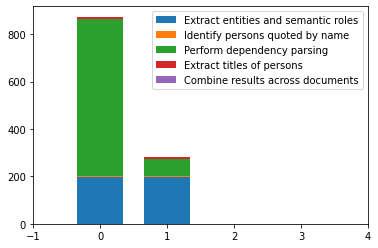

In [31]:
# TODO: Pretty up this plot and get the legend in the same order as the bars
import numpy as np

sums = timings_df.sum()

timings = {
    "Extract entities and semantic roles": [sums["step_1_sec"], sums["step_1_sec"]],
    "Identify persons quoted by name": [sums["step_2_sec"],sums["step_2_sec"]],
    "Perform dependency parsing": [sums["step_3_sec"], sums["step_3a_sec"]],
    "Extract titles of persons": [sums["step_4_sec"],sums["step_4_sec"]],
    "Combine results across documents": [0.062, 0.062]
}

print(f"Total time before: {sum([v[0] for v in timings.values()])}")
print(f"Total time after: {sum([v[1] for v in timings.values()])}")

cur_sum = np.zeros(2)
for k, v in timings.items():
    plt.bar([0, 1], v, bottom=cur_sum, label=k, width=0.7)
    cur_sum += np.array(v)
    
plt.xlim([-1, 4])
plt.legend()
plt.show()

After that one-line change, the time spent on dependency parsing across our 190 documents drops from 641 seconds to 72 seconds -- a 9x performance increase!

Overall processing time has gone from 852 seconds to 283 seconds for an end-to-end improvement of 3x.

TODO: Conclusion goes here.

In [32]:
# alt_timings = []
# #for doc_num in range(len(article_htmls)):
# for doc_num in range(3):    
#     doc_html = article_htmls[doc_num]
    
#     start_time = time.time()
    
#     step_1a_html_results = mi.extract_named_entities(doc_html, nlu_api)
#     step_1a_html_time = time.time()
    
#     doc_text = step_1a_html_results["analyzed_text"]
    
#     step_1a_results = mi.extract_named_entities(doc_text, nlu_api)
#     step_1a_time = time.time()
    
#     step_1b_results = mi.extract_semantic_roles(doc_html, nlu_api)
#     step_1b_time = time.time()
    
#     alt_timings.append({
#         "doc": doc_num,
#         "step_1a_html_sec": step_1a_html_time - start_time,
#         "step_1a_sec": step_1a_time - step_1a_html_time,
#         "step_1b_sec": step_1b_time - step_1a_time,
#     })

# alt_timings_df = pd.DataFrame.from_records(alt_timings)
# alt_timings_df

In [33]:
# Another pass to time the NLU models separately
# timings = []

# for doc_num in range(len(article_htmls)):
# #for doc_num in range(3):
#     doc_html = article_htmls[doc_num]
    
#     start_time = time.time()
    
#     step_1a_results = mi.extract_named_entities(doc_html, nlu_api)
#     step_1a_time = time.time()
    
#     step_1b_results = mi.extract_semantic_roles(doc_html, nlu_api)
#     step_1b_time = time.time()
    
#     timings.append({
#         "doc": doc_num,
#         "step_1a_sec": step_1a_time - start_time,
#         "step_1b_sec": step_1b_time - step_1a_time,
#     })

# timings_df = timings_df.merge(pd.DataFrame.from_records(timings))
# timings_df["step_1_diff"] = (timings_df["step_1a_sec"] + timings_df["step_1b_sec"]
#                              - timings_df["step_1_sec"])
# step_5_results